In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

import nltk
import ssl
import random
import re

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
from nltk.corpus import stopwords

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package stopwords to /Users/jaden/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# load data
train_df = pd.read_json("../instructions/train.json")
test_df = pd.read_json("../instructions/test.json")
train_df.head()

,reviews,sentiments
0,I bought this belt for my daughter in-law for ...,1
1,The size was perfect and so was the color. It...,1
2,"Fits and feels good, esp. for doing a swim rac...",1
3,These socks are absolutely the best. I take pi...,1
4,Thank you so much for the speedy delivery they...,1


In [19]:
# clean data
def clean_text(text):
    if not text:
        return []
    
    # get stopwords
    excluded = set(stopwords.words('english'))
    
    # remove email addresses
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)

    # replace '@' with 'at' and '#' with ''
    text = text.replace('@', 'at')
    text = text.replace('#', '')

    # normalize text: lowercase, remove non-alphabetic characters, and extra spaces
    text = re.sub(r'[^a-z\s]', ' ', text.lower())
    text = re.sub(r'\s+', ' ', text).strip()
    
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # filter out stopwords
    words = [word for word in text.split() if word not in excluded]
    
    return words

In [20]:
# create flags for train and test dfs
train_df['flag'] = 'train'
test_df['flag'] = 'test'

# combine dfs and override reviews with clean text
combined_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
combined_df['reviews'] = combined_df['reviews'].apply(clean_text)

In [21]:
# get cleaned train reviews
train_reviews = combined_df[combined_df['flag'] == 'train']['reviews']

# find no. of unique words in train dataset
unique_words = set(word for review in train_reviews for word in review)

len(unique_words)

13528

In [22]:
train_df = combined_df[combined_df['flag'] == 'train'].reset_index(drop=True)
test_df = combined_df[combined_df['flag'] == 'test'].reset_index(drop=True)

# encode train and test data using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, tokenizer=lambda x: x, preprocessor=lambda x: x)
vectorizer = vectorizer.fit(train_df['reviews'])
X_train = vectorizer.transform(train_df['reviews'])
X_test = vectorizer.transform(test_df['reviews'])

# split the train data into train and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, train_df['sentiments'], test_size=0.2, random_state=42
)

print(f"Train set size: {X_train_split.shape[0]}")
print(f"Validation set size: {X_val_split.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Train set size: 5920
Validation set size: 1481
Test set size: 1851


In [23]:
# convert sparse TF-IDF matrices to dense tensors
X_train_tensor = torch.tensor(X_train_split.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_split.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_split.toarray(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_split.values, dtype=torch.long)

# create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [24]:
# define model with weights
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout_rate=0.2):
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, 2)

        # custom weight initialization
        init.xavier_uniform_(self.fc1.weight)
        init.zeros_(self.fc1.bias)
        init.xavier_uniform_(self.fc2.weight)
        init.zeros_(self.fc2.bias)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [25]:
# parameters
input_dim = X_train_tensor.shape[1]
hidden_dim = 128          
dropout_rate = 0.2       
learning_rate = 0.0005    
batch_size = 64          
num_epochs = 20         

# create model, criterion, optimizer
model = SentimentClassifier(input_dim, hidden_dim, dropout_rate)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

In [26]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# implement early stopping to prevent overfitting
best_val_loss = float('inf')
patience = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # calc training accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_acc = correct_train / total_train
    train_accuracies.append(train_acc)

    # validation
    model.eval()
    total_val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_acc = (np.array(all_preds) == np.array(all_labels)).mean()
    val_accuracies.append(val_acc)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, "
          f"Training Accuracy: {train_acc:.4f}, "
          f"Validation Accuracy: {val_acc:.4f}, "
          f"Validation F1-score: {val_f1:.4f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0 
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1/20, Loss: 0.4884, Validation Loss: 0.3711, Training Accuracy: 0.8495, Validation Accuracy: 0.8589, Validation F1-score: 0.7937
Epoch 2/20, Loss: 0.3415, Validation Loss: 0.3182, Training Accuracy: 0.8527, Validation Accuracy: 0.8616, Validation F1-score: 0.8001
Epoch 3/20, Loss: 0.2579, Validation Loss: 0.2547, Training Accuracy: 0.8764, Validation Accuracy: 0.8980, Validation F1-score: 0.8737
Epoch 4/20, Loss: 0.1771, Validation Loss: 0.2207, Training Accuracy: 0.9375, Validation Accuracy: 0.9190, Validation F1-score: 0.9090
Epoch 5/20, Loss: 0.1266, Validation Loss: 0.2114, Training Accuracy: 0.9615, Validation Accuracy: 0.9251, Validation F1-score: 0.9177
Epoch 6/20, Loss: 0.0961, Validation Loss: 0.2131, Training Accuracy: 0.9736, Validation Accuracy: 0.9264, Validation F1-score: 0.9194
Epoch 7/20, Loss: 0.0759, Validation Loss: 0.2139, Training Accuracy: 0.9807, Validation Accuracy: 0.9271, Validation F1-score: 0.9214
Epoch 8/20, Loss: 0.0598, Validation Loss: 0.2210, Trai

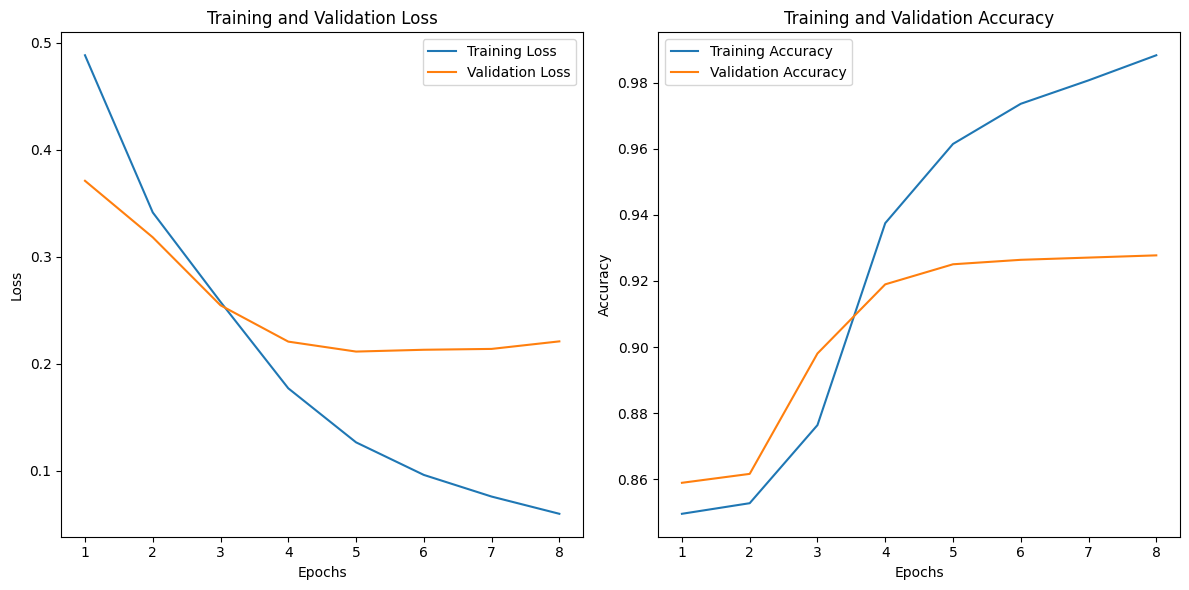

In [27]:
# create plots of train and val loss/accuracy vs epochs
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))

# training and validation loss vs epochs
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# training and validation accuracy vs epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Final Validation Accuracy: 0.9278
Final Validation F1-Score: 0.9220


<Figure size 800x600 with 0 Axes>

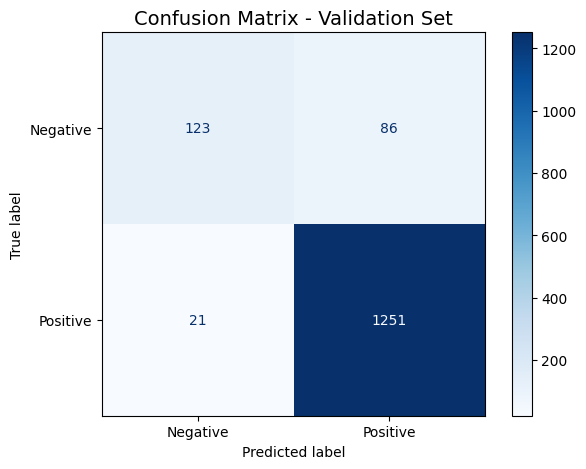

In [28]:
model.eval()
val_preds = []
val_true = []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        val_preds.extend(predicted.cpu().numpy())
        val_true.extend(labels.cpu().numpy())

# calculate final validation metrics
val_accuracy = (np.array(val_preds) == np.array(val_true)).mean()
val_f1 = f1_score(val_true, val_preds, average='weighted')

print(f"Final Validation Accuracy: {val_accuracy:.4f}")
print(f"Final Validation F1-Score: {val_f1:.4f}")

# plot confusion matrix for validation data
cm = confusion_matrix(val_true, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Validation Set', fontsize=14)
plt.tight_layout()
plt.show()

In [29]:
# convert test data to tensor
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64)

# predict test data
model.eval()
test_preds = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_preds.extend(predicted.cpu().numpy())

# add predictions to test_df
test_df = pd.read_json("../instructions/test.json")
test_df['sentiments'] = test_preds
test_df

,reviews,sentiments
0,I bought 2 sleepers. sleeper had holes in the...,0
1,I dare say these are just about the sexiest th...,1
2,"everything about the transaction (price, deliv...",1
3,"Not bad for just a shirt. Very durable, and m...",1
4,These are truly wrinkle free and longer than t...,1
...,...,...
1846,These are stylish and nice and perfect to wear...,1
1847,We bought these long-sleeved colored shirts fo...,1
1848,These are really cute and very sexy. They wil...,1
1849,These shoers were for my daughter. She loves ...,1


In [30]:
# save submissions csv file
test_df.to_csv('submissions.csv', index=False)
print(f"Total test samples: {len(test_preds)}")
print(f"Predicted Negative (0): {sum(np.array(test_preds) == 0)}")
print(f"Predicted Positive (1): {sum(np.array(test_preds) == 1)}")

Total test samples: 1851
Predicted Negative (0): 198
Predicted Positive (1): 1653
